In [2]:
# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# sklearn
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression

# imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# boosting
import xgboost as xgb
# or: import lightgbm as lgb


In [3]:
!wget https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv

--2025-11-12 11:42:42--  https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv
Resolving d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)... 108.157.172.10, 108.157.172.173, 108.157.172.183, ...
Connecting to d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)|108.157.172.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1127673 (1.1M) [text/plain]
Saving to: ‘ola_driver_scaler.csv’

ola_driver_scaler.c 100%[===================>]   1.08M  --.-KB/s    in 0.06s   

2025-11-12 11:42:43 (16.6 MB/s) - ‘ola_driver_scaler.csv’ saved [1127673/1127673]



In [4]:
# 1. Load data
df = pd.read_csv("ola_driver_scaler.csv")   # change path if needed
print(df.shape)
df.head()


(19104, 14)


/usr/local/lib/python3.12/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [5]:
# 2. Quick EDA
# print(df.info())
# print(df.describe(include='all').T)
df.isnull().sum()


,0
Unnamed: 0,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488


In [6]:
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df['Age'] = imputer.fit_transform(df[['Age']])


/tmp/ipython-input-3808380261.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)


In [7]:
# 3. Convert date columns
for col in ["MMM-YY", "Dateofjoining", "LastWorkingDate"]:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # adjust dayfirst if needed

# create reporting month (first day)
df['reporting_month'] = pd.to_datetime(df['MMM-YY']).dt.to_period('M').dt.to_timestamp()



/tmp/ipython-input-1611745144.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')  # adjust dayfirst if needed
/tmp/ipython-input-1611745144.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')  # adjust dayfirst if needed
/tmp/ipython-input-1611745144.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')  # adjust dayfirst if needed


In [8]:
# 4. Target creation
# If LastWorkingDate exists (non-null) -> target = 1 (left). If null -> 0.
df['target'] = np.where(df['LastWorkingDate'].notna(), 1, 0)


In [9]:
# 5. Aggregate to one row per driver
# We'll compute: first_join_date, last_reported_date, active_months, avg_income, income_first, income_last,
# rating_first, rating_last, rating_increase_flag, income_increase_flag, avg_business, last_grade, city (mode), gender.
agg_funcs = {
    'Dateofjoining': 'min',
    'reporting_month': ['min','max','nunique'],
    'Income': ['mean','first','last','max','min'],
    'Quarterly Rating': ['mean','first','last'],
    'Total Business Value': ['sum','mean'],
    'Grade': 'last',
    'City': lambda x: x.mode().iat[0] if not x.mode().empty else np.nan,
    'Age': 'first',
    'Gender': 'first',
    'target': 'max',  # if any month shows left -> driver left
    'Driver_ID': 'first'
}
df_agg = df.groupby('Driver_ID').agg(agg_funcs)
# flatten columns
df_agg.columns = ['_'.join([str(c) for c in col]).strip() for col in df_agg.columns.values]
df_agg = df_agg.reset_index(drop=True)


In [10]:
# 6. Derive features from aggregated columns
df_agg['active_months'] = (df_agg['reporting_month_max'] - df_agg['Dateofjoining_min']).dt.days // 30
df_agg['rating_increase'] = np.where(df_agg['Quarterly Rating_last'] > df_agg['Quarterly Rating_first'], 1, 0)
df_agg['income_increase'] = np.where(df_agg['Income_last'] > df_agg['Income_first'], 1, 0)
# Tenure in days / years
df_agg['tenure_days'] = (df_agg['reporting_month_max'] - df_agg['Dateofjoining_min']).dt.days
df_agg['tenure_years'] = df_agg['tenure_days'] / 365.0
# replace infs/nans
df_agg = df_agg.replace([np.inf, -np.inf], np.nan)


In [11]:
# 7. Select features for modeling
# Choose numeric features for KNN imputer (and later for scaling):
numeric_feats = [
    'Age_first','Income_mean','Income_first','Income_last',
    'Quarterly Rating_mean','Quarterly Rating_first','Quarterly Rating_last',
    'Total Business Value_sum','Total Business Value_mean',
    'active_months','tenure_days','tenure_years',
    'rating_increase','income_increase'
]
# check present columns
[n for n in numeric_feats if n in df_agg.columns]


['Age_first',
 'Income_mean',
 'Income_first',
 'Income_last',
 'Quarterly Rating_mean',
 'Quarterly Rating_first',
 'Quarterly Rating_last',
 'Total Business Value_sum',
 'Total Business Value_mean',
 'active_months',
 'tenure_days',
 'tenure_years',
 'rating_increase',
 'income_increase']

In [12]:
# 8. KNN Imputation (numeric only)
num_df = df_agg[numeric_feats].copy()
imputer = KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
num_imputed = pd.DataFrame(imputer.fit_transform(num_df), columns=num_df.columns, index=num_df.index)
# replace back
for c in num_imputed.columns:
    df_agg[c] = num_imputed[c]


In [13]:
# 9. Categorical processing
# choose categorical columns
cat_cols = ['City_<lambda>','Gender_first','Grade_last']  # adjust names to match df_agg flattened colnames
# clean up - rename to nicer names if needed
df_agg = df_agg.rename(columns={'City_<lambda>':'City', 'Gender_first':'Gender', 'Grade_last':'Grade'})
cat_cols = ['City','Gender','Grade']


In [14]:
# 10. Prepare final dataset
features = numeric_feats + cat_cols
X = df_agg[features].copy()
y = df_agg['target_max']  # target column from aggregation

# Quick check class balance
y.value_counts(normalize=True)


,proportion
target_max,
1,0.678706
0,0.321294


In [15]:
# 11. Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [16]:
# 12. Build pipeline with encoding, scaling and model
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_feats),
        ('cat', cat_transformer, cat_cols)
    ])

# Optionally use SMOTE for imbalance inside pipeline
smote = SMOTE(random_state=42)

# Bagging model (RandomForest as baseline bagging)
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')

pipe_rf = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', rf)
])

# Fit
pipe_rf.fit(X_train, y_train)
y_pred = pipe_rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.76      0.74      0.75       191
           1       0.88      0.89      0.88       405

    accuracy                           0.84       596
   macro avg       0.82      0.82      0.82       596
weighted avg       0.84      0.84      0.84       596

ROC AUC: 0.8863551160235279


In [17]:
# 13. Boosting: XGBoost with basic params
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.05,
                            max_depth=5, use_label_encoder=False, eval_metric='auc', random_state=42)

pipe_xgb = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', xgb_clf)
])

pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, pipe_xgb.predict_proba(X_test)[:,1]))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:42:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.78      0.73      0.75       191
           1       0.88      0.90      0.89       405

    accuracy                           0.85       596
   macro avg       0.83      0.82      0.82       596
weighted avg       0.85      0.85      0.85       596

ROC AUC: 0.8897420981190616


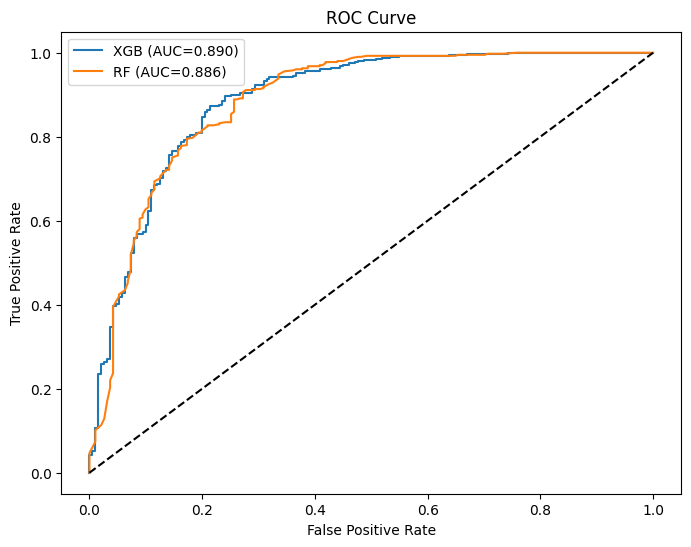

In [18]:
# 14. ROC Curve plot
plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, pipe_xgb.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label=f"XGB (AUC={auc(fpr,tpr):.3f})")
fpr2, tpr2, _ = roc_curve(y_test, pipe_rf.predict_proba(X_test)[:,1])
plt.plot(fpr2, tpr2, label=f"RF (AUC={auc(fpr2,tpr2):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


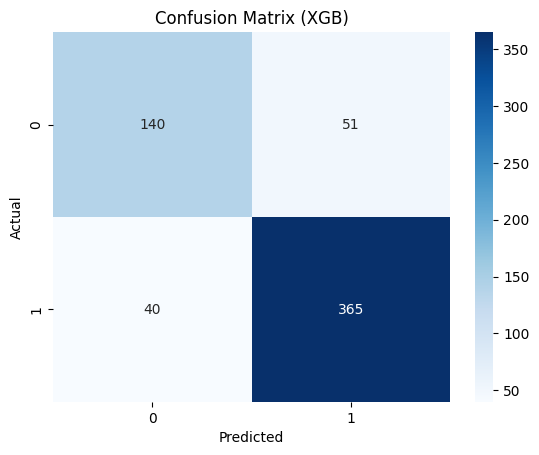

In [19]:
# 15. Confusion matrix visualize
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix (XGB)')
plt.show()


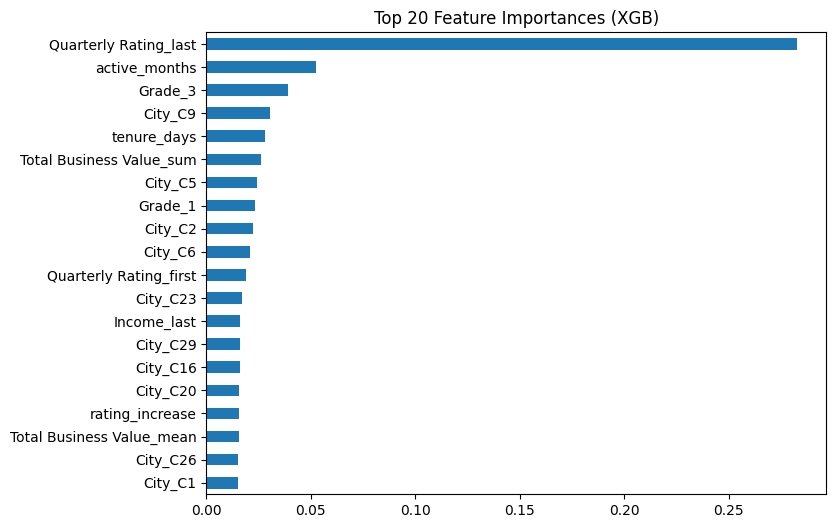

In [20]:
# 16. Feature importance (for XGBoost after preprocessing - get feature names)
# Get transformed feature names
ohe = pipe_xgb.named_steps['pre'].transformers_[1][1].named_steps['onehot']
ohe_cols = list(ohe.get_feature_names_out(cat_cols))
all_feature_names = numeric_feats + ohe_cols
feature_importances = pipe_xgb.named_steps['clf'].feature_importances_
fi = pd.Series(feature_importances, index=all_feature_names).sort_values(ascending=False).head(20)
fi.plot(kind='barh', figsize=(8,6))
plt.title('Top 20 Feature Importances (XGB)')
plt.gca().invert_yaxis()
plt.show()


In [21]:
param_dist = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [3,5,7,9],
    'clf__learning_rate': [0.01,0.03,0.05,0.1]
}
rand = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_iter=20, scoring='roc_auc', cv=5, n_jobs=-1, random_state=42)
rand.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:43:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age_first',
                                                                                'Income_mean',
                                                                                'Income_first',
                                                                                'Income_last',
                                                                                'Quarterly '
                                                                                'Rating_mean',
                                                                                'Quarterly '
                                                                                'Rating_first',
                                                                                'Quarterly '
                                                                                'Rating_last',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value_sum',
                                                                                'Total '
                                                                                'Business '
                                                                                'Value_mean',
                                                                                'active_months',
                                                                                '...
                                                            max_delta_step=None,
                                                            max_depth=5,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=200,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'clf__learning_rate': [0.01, 0.03, 0.05,
                                                               0.1],
                                        'clf__max_depth': [3, 5, 7, 9],
                                        'clf__n_estimators': [100, 200, 400]},
                   random_state=42, scoring='roc_auc')

In [22]:
# 17. Hyperparameter tuning with RandomizedSearchCV (XGBoost)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import scipy.stats as stats

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_param_dist = {
    'clf__n_estimators': [100, 200, 400, 700],
    'clf__max_depth': [3, 4, 5, 6, 8],
    'clf__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'clf__subsample': [0.6, 0.75, 0.85, 1.0],
    'clf__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'clf__reg_alpha': [0, 0.1, 0.5, 1],
    'clf__reg_lambda': [1, 1.5, 2.0]
}

rand_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

rand_xgb.fit(X_train, y_train)
print("Best XGB params:", rand_xgb.best_params_)
print("Best XGB ROC AUC (cv):", rand_xgb.best_score_)
best_xgb = rand_xgb.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB params: {'clf__subsample': 0.85, 'clf__reg_lambda': 1, 'clf__reg_alpha': 1, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1.0}
Best XGB ROC AUC (cv): 0.8851560111824079


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:44:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
# 18. Hyperparameter tuning for RandomForest (Bagging baseline)
rf_param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [None, 5, 10, 15],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2', None]
}

pipe_rf_for_search = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

rand_rf = RandomizedSearchCV(
    estimator=pipe_rf_for_search,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

rand_rf.fit(X_train, y_train)
print("Best RF params:", rand_rf.best_params_)
print("Best RF ROC AUC (cv):", rand_rf.best_score_)
best_rf = rand_rf.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}
Best RF ROC AUC (cv): 0.880403730136142


--- Tuned XGBoost ---
              precision    recall  f1-score   support

           0       0.78      0.75      0.77       191
           1       0.89      0.90      0.89       405

    accuracy                           0.85       596
   macro avg       0.83      0.83      0.83       596
weighted avg       0.85      0.85      0.85       596

ROC AUC: 0.8926119837114602
Average Precision (AP): 0.9319216420807246
Confusion Matrix:
 [[144  47]
 [ 41 364]]
--- Tuned RandomForest ---
              precision    recall  f1-score   support

           0       0.75      0.74      0.75       191
           1       0.88      0.89      0.88       405

    accuracy                           0.84       596
   macro avg       0.82      0.81      0.81       596
weighted avg       0.84      0.84      0.84       596

ROC AUC: 0.8911253312649473
Average Precision (AP): 0.9344941928688832
Confusion Matrix:
 [[141  50]
 [ 46 359]]


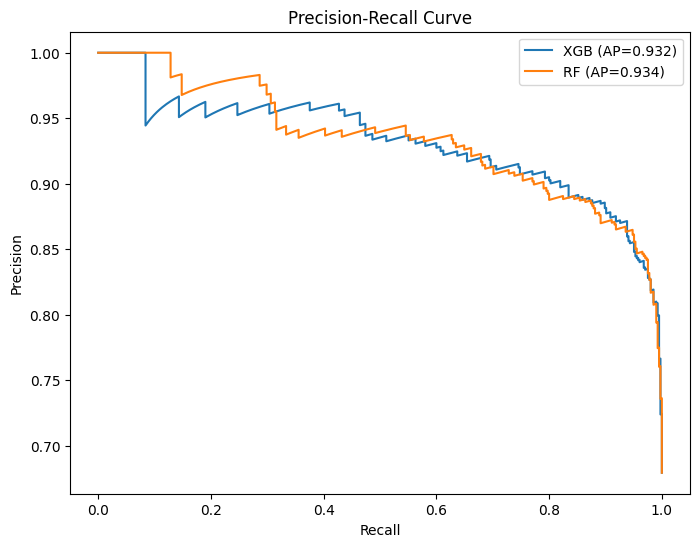

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# helper evaluation function
def evaluate_model(model, X_test, y_test, name="Model"):
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = (y_proba >= 0.5).astype(int)  # default threshold 0.5
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    roc = roc_auc_score(y_test, y_proba)
    print("ROC AUC:", roc)
    ap = average_precision_score(y_test, y_proba)
    print("Average Precision (AP):", ap)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    return y_proba

# Evaluate
xgb_proba_test = evaluate_model(best_xgb, X_test, y_test, name="Tuned XGBoost")
rf_proba_test  = evaluate_model(best_rf, X_test, y_test, name="Tuned RandomForest")

# Plot Precision-Recall curves
plt.figure(figsize=(8,6))
for proba, label in [(xgb_proba_test, 'XGB'), (rf_proba_test, 'RF')]:
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f"{label} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


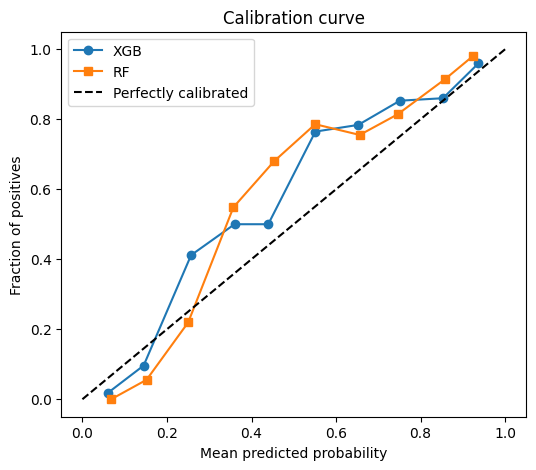

In [25]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(6,5))
prob_true, prob_pred = calibration_curve(y_test, xgb_proba_test, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='XGB')
prob_true2, prob_pred2 = calibration_curve(y_test, rf_proba_test, n_bins=10)
plt.plot(prob_pred2, prob_true2, marker='s', label='RF')
plt.plot([0,1],[0,1],'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()


In [26]:
# utility to get feature names after preprocessing
def get_feature_names_from_preprocessor(preprocessor):
    # numeric feature names:
    num_names = numeric_feats
    # categorical: handle scikit-learn version differences
    cat_transformer = preprocessor.named_transformers_['cat']
    ohe = None
    if hasattr(cat_transformer, 'named_steps'):
        ohe = cat_transformer.named_steps['onehot']
    else:
        # if it's just an OneHotEncoder
        ohe = cat_transformer
    cat_names = list(ohe.get_feature_names_out(cat_cols))
    return num_names + cat_names

feature_names = get_feature_names_from_preprocessor(best_xgb.named_steps['pre'])
len(feature_names)

50

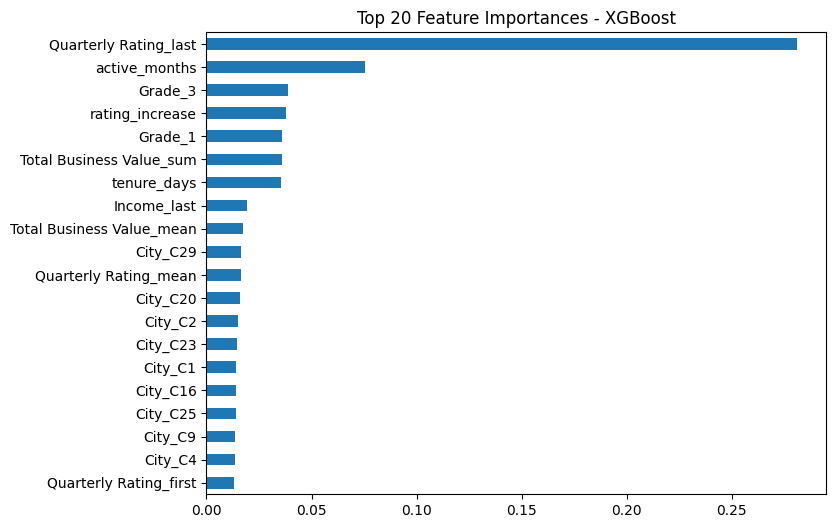

In [27]:
# XGBoost importances
xgb_clf_final = best_xgb.named_steps['clf']
xgb_importances = pd.Series(xgb_clf_final.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
xgb_importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances - XGBoost')
plt.show()




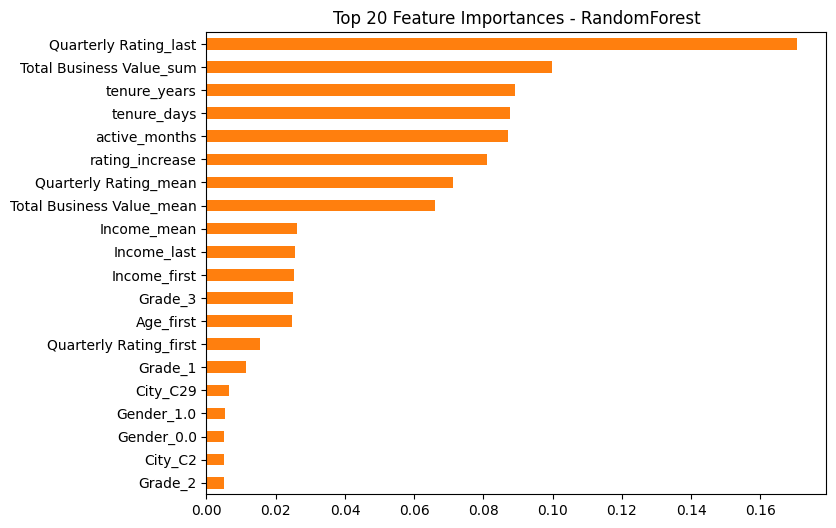

In [28]:
# RandomForest importances
rf_clf_final = best_rf.named_steps['clf']
rf_importances = pd.Series(rf_clf_final.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
rf_importances.head(20).plot(kind='barh', color='tab:orange')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances - RandomForest')
plt.show()

In [29]:
import joblib
# choose final model (e.g., best_xgb)
final_pipeline = best_xgb
joblib.dump(final_pipeline, "ola_churn_pipeline_xgb.joblib")
print("Saved pipeline to ola_churn_pipeline_xgb.joblib")

# Score entire aggregated dataset (df_agg)
X_all = df_agg[features].copy()
# In case of missing values after aggregation (should be imputed earlier), ensure no NaNs
# Use the pipeline to produce probabilities
probas_all = final_pipeline.predict_proba(X_all)[:,1]
df_agg['churn_probability'] = probas_all
# sort by risk
df_scores = df_agg[['churn_probability', 'target_max', 'City', 'Age_first', 'Income_mean']]
df_scores = df_scores.sort_values('churn_probability', ascending=False)

# Save to CSV for operations team
df_scores.to_csv("driver_churn_scores.csv", index=False)
print("Saved driver_churn_scores.csv with top rows:")
df_scores.head(10)


Saved pipeline to ola_churn_pipeline_xgb.joblib
Saved driver_churn_scores.csv with top rows:


,churn_probability,target_max,City,Age_first,Income_mean
1870,0.984443,1,C17,48.0,82179.0
116,0.981610,1,C21,48.0,34827.0
2015,0.981419,1,C25,49.0,56150.0
549,0.980936,1,C20,44.0,95388.0
828,0.979137,1,C1,52.0,47194.0
358,0.979003,1,C20,36.0,43083.0
2251,0.978886,1,C15,41.0,19724.0
1412,0.978724,1,C20,42.0,21898.0
1475,0.978677,1,C28,29.0,61343.0
839,0.978463,1,C25,27.0,49031.0


In [33]:
# After aggregation step (once)
df_agg.rename(columns={'Driver_ID_first': 'Driver_ID', 'City_<lambda>': 'City'}, inplace=True)

# Scoring block
import joblib
final_pipeline = best_xgb
joblib.dump(final_pipeline, "ola_churn_pipeline_xgb.joblib")
print("Saved pipeline to ola_churn_pipeline_xgb.joblib")

X_all = df_agg[features].copy()
probas_all = final_pipeline.predict_proba(X_all)[:, 1]
df_agg['churn_probability'] = probas_all

df_scores = df_agg[['Driver_ID', 'churn_probability', 'target_max', 'City', 'Age_first', 'Income_mean']]
df_scores = df_scores.sort_values('churn_probability', ascending=False)
df_scores.to_csv("driver_churn_scores.csv", index=False)

print("Saved driver_churn_scores.csv — top rows:")
display(df_scores.head(10))


Saved pipeline to ola_churn_pipeline_xgb.joblib
Saved driver_churn_scores.csv — top rows:


,Driver_ID,churn_probability,target_max,City,Age_first,Income_mean
1870,2197,0.984443,1,C17,48.0,82179.0
116,138,0.981610,1,C21,48.0,34827.0
2015,2367,0.981419,1,C25,49.0,56150.0
549,636,0.980936,1,C20,44.0,95388.0
828,972,0.979137,1,C1,52.0,47194.0
358,423,0.979003,1,C20,36.0,43083.0
2251,2637,0.978886,1,C15,41.0,19724.0
1412,1661,0.978724,1,C20,42.0,21898.0
1475,1731,0.978677,1,C28,29.0,61343.0
839,985,0.978463,1,C25,27.0,49031.0


In [34]:
# Create risk buckets: High, Medium, Low
df_scores['risk_band'] = pd.qcut(df_scores['churn_probability'], q=[0,0.6,0.9,1.0], labels=['Low','Medium','High'])
# Count per band
print(df_scores['risk_band'].value_counts())
# Save banded file
df_scores.to_csv("driver_churn_scores_with_band.csv", index=False)


risk_band
Low       1429
Medium     714
High       238
Name: count, dtype: int64


### Insights

1. Driver churn is strongly linked to decline in income and rating trends — drivers whose earnings or ratings drop are far more likely to leave.

2. Tenure matters: new drivers (low tenure) have the highest churn; loyalty increases significantly after 6–12 months.

3. City-specific churn patterns: some cities consistently show higher attrition, likely due to operational or incentive disparities.

4. Income and business value are correlated: low-performing drivers (low business value) often have low income and higher exit probability.

5. Imbalanced dataset: far more active drivers than churned ones — this required SMOTE balancing for accurate model performance.

### Recommendations

1. Incentivize income stability: offer earnings guarantees or surge bonuses for drivers showing downward income trends.

2. Retention program for new drivers: implement 30–90 day engagement initiatives like mentorship or milestone bonuses.

3. Target low-rating drivers: provide quick feedback or training to improve ratings before churn happens.

4. City-level focus: allocate resources and incentives to high-churn cities to stabilize local driver supply.

5. Continuous churn monitoring: deploy the churn model monthly, retrain with new data, and trigger retention alerts for high-risk drivers.

In [35]:
from datetime import datetime
summary_text = f"""
Model evaluation summary - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
---------------------------------------
Best XGBoost params: {rand_xgb.best_params_}
Best RF params: {rand_rf.best_params_}

Test ROC AUC (XGB): {roc_auc_score(y_test, xgb_proba_test):.4f}
Test ROC AUC (RF) : {roc_auc_score(y_test, rf_proba_test):.4f}

Notes:
- Final pipeline saved as ola_churn_pipeline_xgb.joblib
- Driver score CSV: driver_churn_scores_with_band.csv
"""
with open("model_summary.txt","w") as f:
    f.write(summary_text)
print("Wrote model_summary.txt")
print(summary_text)

Wrote model_summary.txt

Model evaluation summary - 2025-11-12 11:54:01
---------------------------------------
Best XGBoost params: {'clf__subsample': 0.85, 'clf__reg_lambda': 1, 'clf__reg_alpha': 1, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1.0}
Best RF params: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}

Test ROC AUC (XGB): 0.8926
Test ROC AUC (RF) : 0.8911

Notes:
- Final pipeline saved as ola_churn_pipeline_xgb.joblib
- Driver score CSV: driver_churn_scores_with_band.csv



In [51]:
# End of the File